In [97]:
import os
import pandas as pd
import numpy as np
import json
import pickle
from collections import defaultdict
from pathlib import Path
from statistics import mean, stdev
from sklearn.metrics import ndcg_score, dcg_score
import matplotlib.pyplot as plt
import seaborn as sns

import torch

import os, sys
parentPath = os.path.abspath("..")
if parentPath not in sys.path:
    sys.path.insert(0, parentPath)
    
from src.data import load_source
from src.config import Config, get_option_fallback
from src.path import get_best_model_paths, get_exp_paths, get_report_path, load_json, load_rep_cfg
from knowledge_tracing.trainer import Trainer

In [3]:
projectdir = Path('/code')
assert projectdir.exists()

# Common Functions

In [181]:
def summarize_test_res(rep, folds=5):
    print(rep['config']['exp_name'], end=':\t')
    s = pd.Series([rep['best']['auc_epoch'][str(i)] for i in range(folds)])
    print(f'Best epoch at {s.mean():>6.1f}±{s.std():<5.1f}', end='\t')
    s = pd.Series([rep['best']['auc'][str(i)] for i in range(folds)])
    print(f'Valid AUC: {s.mean()*100:.4f}±{s.std()*100:.4f}', end='\t')
    s = pd.Series([rep['indicator']['test_auc'][str(i)][0] for i in range(folds)])
    print(f'Test AUC: {s.mean()*100:.4f}±{s.std()*100:.4f}', end='\t')
    s = rep['indicator']['RPsoft']['all']
    print(f'Good:Bad = {s["good"]}:{s["bad"]}', end='\t')
    s = rep['indicator']['test_auc']['all'][0]
    print(f'All Test AUC: {s*100:.4f}')

In [143]:
def show_valid_lc(name, idclist_dic, idc='eval_auc'):
    min_len = min([len(_x) for _x in idclist_dic['epoch'].values()])
    x = idclist_dic['epoch']['0'][:min_len] * (len(idclist_dic['epoch']) -1)  # exclude 'all'
    y = []
    for _y in idclist_dic[idc].values():
        y += _y[:min_len]
    sns.lineplot(x=x, y=y, label=name)
    plt.title(idc)

In [193]:
def summarize_results(config_name, folds=5):
    report_list = []
    for r in sorted([load_json(get_report_path(projectdir, e)) for e in get_exp_paths(projectdir, config_name)], key=lambda x: x['config']['pre_dummy_epoch_size']):
        report_list.append(r)
    df = pd.DataFrame(columns=['dataset', 'model', 'auc', 'auc_std', 'r1_good', 'r1_goodbad', 'r2', 'r2_std'])
    for r in report_list:
        row = {
            'dataset':   r['config']['config_name'],
            'model':     r['config']['exp_name'],
            'auc':       mean([r['indicator']['test_auc'][str(i)][0] for i in range(folds)]),
            'auc_std':   stdev([r['indicator']['test_auc'][str(i)][0] for i in range(folds)]) if folds > 1 else np.nan,
            'r1_good':       r['indicator']['RPsoft']['all']['good'],
            'r1_goodbad':       r['indicator']['RPsoft']['all']['good'] + r['indicator']['RPsoft']['all']['bad'],
            'r2':      mean(r['indicator']['RPhard']['all']),
            'r2_std': stdev(r['indicator']['RPhard']['all'])
        }
        df = df.append(row, ignore_index=True)
    return df
        

# Summary

## AUC table

In [199]:
summarize_results('20_0310_edm2020_assist09')

,dataset,model,auc,auc_std,r1_good,r1_goodbad,r2,r2_std
0,20_0310_edm2020_assist09,pre_dummy_epoch_size0.auto,0.802399,0.002135,91,110,0.885842,0.121002
1,20_0310_edm2020_assist09,pre_dummy_epoch_size10.auto,0.802763,0.001107,105,110,0.916217,0.103119
2,20_0310_edm2020_assist09,pre_dummy_epoch_size150.auto,0.805398,0.000801,106,110,0.897429,0.112539


In [195]:
summarize_results('20_0310_edm2020_assist15')

,dataset,model,auc,auc_std,r1_good,r1_goodbad,r2,r2_std
0,20_0310_edm2020_assist15,pre_dummy_epoch_size0.auto,0.703117,0.001366,99,100,0.924388,0.091456
1,20_0310_edm2020_assist15,pre_dummy_epoch_size10.auto,0.703355,0.000890,99,100,0.921136,0.096746
2,20_0310_edm2020_assist15,pre_dummy_epoch_size150.auto,0.705414,0.001263,95,100,0.927833,0.092699


In [196]:
summarize_results('20_0310_edm2020_synthetic', folds=1)

,dataset,model,auc,auc_std,r1_good,r1_goodbad,r2,r2_std
0,20_0310_edm2020_synthetic,pre_dummy_epoch_size0.auto,0.777116,NaN,26,50,0.792350,0.130606
1,20_0310_edm2020_synthetic,pre_dummy_epoch_size10.auto,0.776778,NaN,44,50,0.894807,0.115647
2,20_0310_edm2020_synthetic,pre_dummy_epoch_size150.auto,0.773313,NaN,46,50,0.890824,0.113911


In [283]:
summarize_results('20_0310_edm2020_statics')

,dataset,model,auc,auc_std,r1_good,r1_goodbad,r2,r2_std
0,20_0310_edm2020_statics,pre_dummy_epoch_size0.auto,0.787167,0.000661,639,1223,0.778891,0.149663
1,20_0310_edm2020_statics,pre_dummy_epoch_size10.auto,0.794149,0.003777,934,1223,0.885513,0.126757
2,20_0310_edm2020_statics,pre_dummy_epoch_size150.auto,0.792491,0.000426,716,1223,0.809500,0.158295


In [284]:
print(summarize_results('20_0310_edm2020_assist09').to_latex())
print(summarize_results('20_0310_edm2020_assist15').to_latex())
print(summarize_results('20_0310_edm2020_synthetic', folds=1).to_latex())
print(summarize_results('20_0310_edm2020_statics').to_latex())

\begin{tabular}{lllrrllrr}
\toprule
{} &                   dataset &                         model &       auc &   auc\_std & r1\_good & r1\_goodbad &        r2 &    r2\_std \\
\midrule
0 &  20\_0310\_edm2020\_assist09 &    pre\_dummy\_epoch\_size0.auto &  0.802399 &  0.002135 &      91 &        110 &  0.885842 &  0.121002 \\
1 &  20\_0310\_edm2020\_assist09 &   pre\_dummy\_epoch\_size10.auto &  0.802763 &  0.001107 &     105 &        110 &  0.916217 &  0.103119 \\
2 &  20\_0310\_edm2020\_assist09 &  pre\_dummy\_epoch\_size150.auto &  0.805398 &  0.000801 &     106 &        110 &  0.897429 &  0.112539 \\
\bottomrule
\end{tabular}

\begin{tabular}{lllrrllrr}
\toprule
{} &                   dataset &                         model &       auc &   auc\_std & r1\_good & r1\_goodbad &        r2 &    r2\_std \\
\midrule
0 &  20\_0310\_edm2020\_assist15 &    pre\_dummy\_epoch\_size0.auto &  0.703117 &  0.001366 &      99 &        100 &  0.924388 &  0.091456 \\
1 &  20\_0310\_edm2020\_assist15 

## NDCG distplot

In [230]:
def ndcg_distplot(config_name, bins=20):
    report_list = []
    for r in sorted([load_json(get_report_path(projectdir, e)) for e in get_exp_paths(projectdir, config_name)], key=lambda x: x['config']['pre_dummy_epoch_size']):
        if r['config']['pre_dummy_epoch_size'] not in {0, 10}:
            continue
        r['config']['exp_name'] = f"DKT pre {r['config']['pre_dummy_epoch_size']}"
        report_list.append(r)
    for rep in report_list:
        r = rep['indicator']['RPhard']['all']
        name = rep['config']['exp_name']
        sns.distplot(r, bins=bins, label=name, kde_kws={'clip': (0.0, 1.0)})
    plt.legend()
    plt.xlabel('NDCG distribution')
    plt.ylabel('frequency')
    plt.title(config_name)
    plt.show()

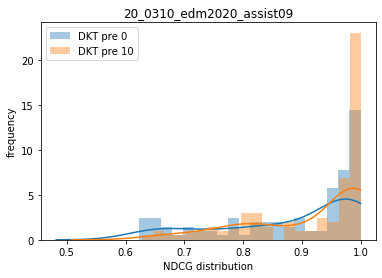

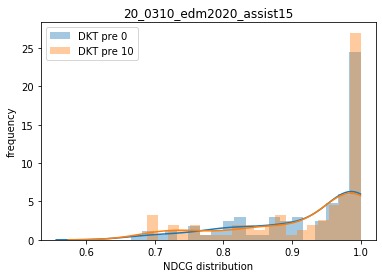

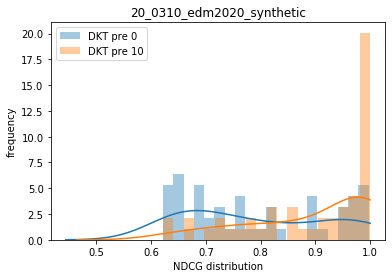

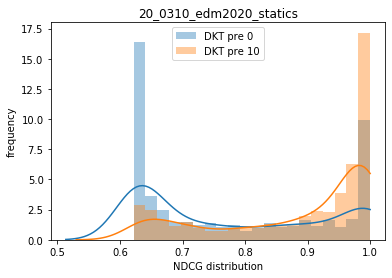

In [248]:
ndcg_distplot('20_0310_edm2020_assist09')
ndcg_distplot('20_0310_edm2020_assist15')
ndcg_distplot('20_0310_edm2020_synthetic')
ndcg_distplot('20_0310_edm2020_statics')

## Learning curve

In [254]:
def lc_plot(config_name):
    report_list = []
    for r in sorted([load_json(get_report_path(projectdir, e)) for e in get_exp_paths(projectdir, config_name)], key=lambda x: x['config']['pre_dummy_epoch_size']):
        if r['config']['pre_dummy_epoch_size'] not in {0, 10}:
            continue
        r['config']['exp_name'] = f"DKT pre {r['config']['pre_dummy_epoch_size']}"
        report_list.append(r)
    for r in report_list:
#         show_valid_lc(r['config']['exp_name'], r['indicator'])
        idclist_dic = r['indicator']
        idc = 'eval_auc'
        min_len = min([len(_x) for _x in idclist_dic['epoch'].values()])
        x = idclist_dic['epoch']['0'][:min_len] * (len(idclist_dic['epoch']) -1)  # exclude 'all'
        y = []
        for _y in idclist_dic[idc].values():
            y += _y[:min_len]
        sns.lineplot(x=x, y=y, label=r['config']['exp_name'], ci='sd')
    plt.title(config_name)
    plt.xlabel('epoch')
    plt.ylabel('AUC')
    plt.show()

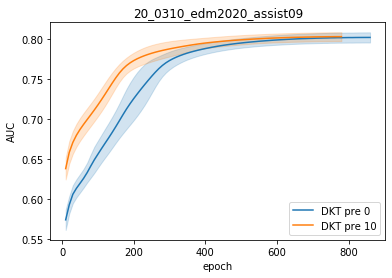

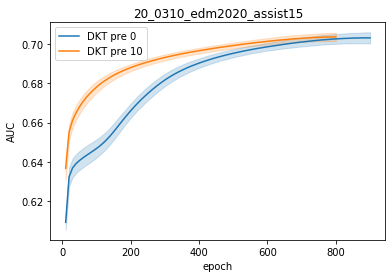

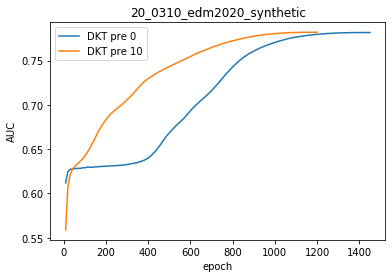

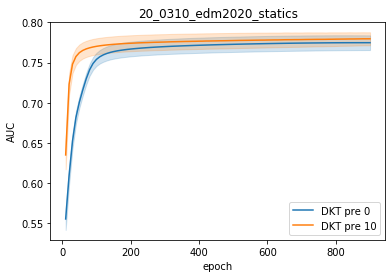

In [255]:
lc_plot('20_0310_edm2020_assist09')
lc_plot('20_0310_edm2020_assist15')
lc_plot('20_0310_edm2020_synthetic')
lc_plot('20_0310_edm2020_statics')

# `20_0310_edm2020_assist09`

## Simulated curve

In [238]:
config_name = '20_0310_edm2020_assist09'
report_list = []
for r in sorted([load_json(get_report_path(projectdir, e)) for e in get_exp_paths(projectdir, config_name)], key=lambda x: x['config']['pre_dummy_epoch_size']):
    if r['config']['pre_dummy_epoch_size'] not in {0, 10}:
        continue
    r['config']['exp_name'] = f"DKT pre {r['config']['pre_dummy_epoch_size']}"
    report_list.append(r)

[r['config']['exp_name'] for r in report_list]

['DKT pre 0', 'DKT pre 10']

In [239]:
def get_simu_res(report_dic):
    return report_dic['indicator']['simu_pred']['all']

simures_list = []
for r in report_list:
    simu_res = get_simu_res(r)
    simures_list.append(simu_res)
    
base_idx = 0
base_res = {k:v for k, v in sorted(simures_list[base_idx].items(), key=lambda it: it[1][1][-1] - it[1][1][0])}
descres_list = []
for i, simu_res in enumerate(simures_list):
    if i == base_idx:
        continue
    desc_res = {k:simu_res[k] for k in base_res.keys()}
    descres_list.append(desc_res)

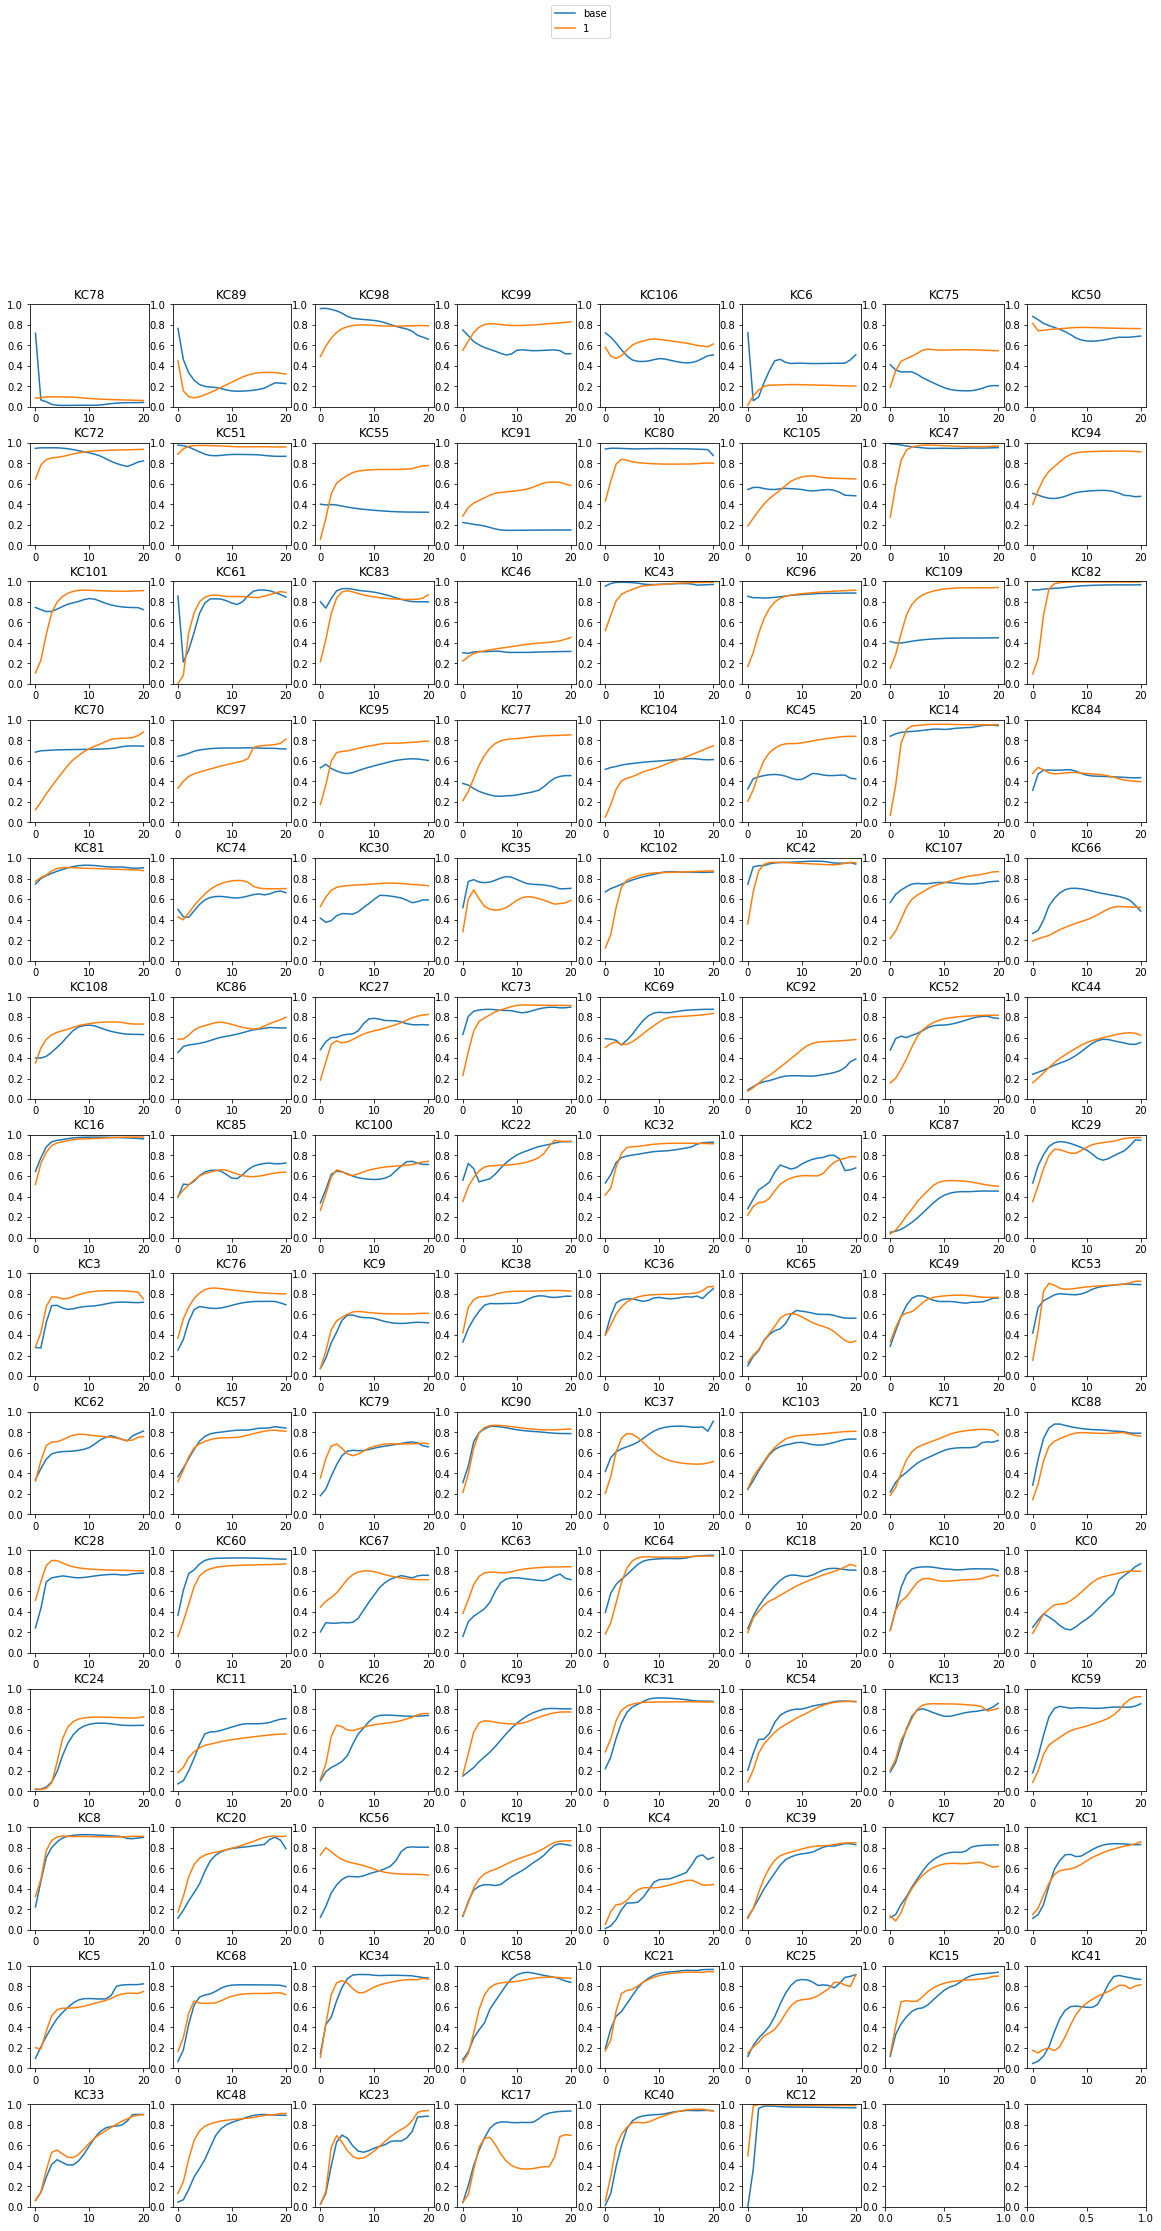

In [240]:
n_skills = report_list[base_idx]['config']['n_skills']
h, w = (n_skills+7)//8, 8
figscale = 2.5
hspace = 0.35
fig, axs = plt.subplots(h, w, figsize=(w*figscale, h*figscale))
plt.subplots_adjust(hspace=hspace)
for i, (v, (xidx, sanity)) in enumerate(list(base_res.items())[:h*w]):
    ax = axs[i//(w), i%(w)]
    ax.set_ylim([0, 1])
    ax.set_title('KC{}'.format(v))
    sns.lineplot(xidx, sanity, ax=ax, label='base', palette="ch:2.5,.25")
    for i, desc_res in enumerate(descres_list):
        sns.lineplot(xidx, desc_res[v][1], ax=ax, label=str(i+1), palette="ch:2.5,.25")
    ax.get_legend().remove()
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center')
plt.show()

## Single ones

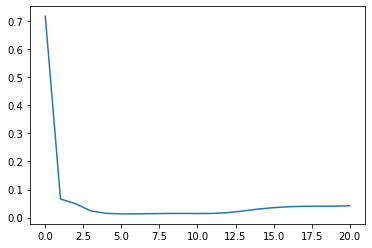

In [261]:
def plot_single(kc):
    x, y = base_res[str(kc)]
    sns.lineplot(x=x, y=y)
plot_single(78)

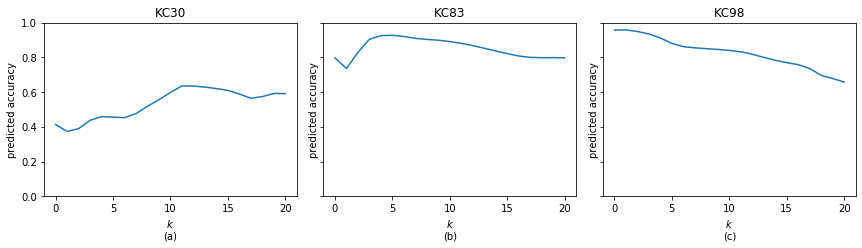

In [282]:
f, axs = plt.subplots(1, 3, sharey=True, figsize=(12,3))
f.tight_layout()
for i, (kc, ax) in enumerate(zip([30, 83, 98], axs)):
    ax.set_ylim([0, 1])
    x, y = base_res[str(kc)]
    sns.lineplot(x=x, y=y, ax=ax)
    ax.set_title(f'KC{kc}')
    ax.set_ylabel('predicted accuracy')
    ax.set_xlabel('$k$\n({})'.format(['a','b','c'][i]))
plt.show()

## NDCG

pre_dummy_epoch_size0.auto	0.8858±0.1210
pre_dummy_epoch_size10.auto	0.9162±0.1031
pre_dummy_epoch_size150.auto	0.8974±0.1125


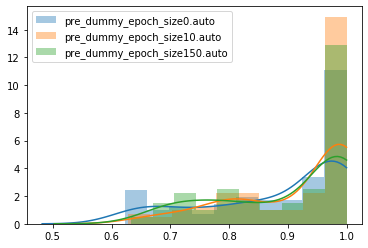

In [141]:
for rep in report_list:
    r = rep['indicator']['RPhard']['all']
    name = rep['config']['exp_name']
    sns.distplot(r, bins=10, label=name, kde_kws={'clip': (0.0, 1.0)})
    print(f'{name:<20s}\t{mean(r):.4f}±{stdev(r):.4f}')
plt.legend()
plt.show()

In [142]:
for rep in report_list:
    r = rep['indicator']['RPsoft']['all']
    name = rep['config']['exp_name']
    print(f'{name:<20s}\tGood:Bad = {r["good"]}:{r["bad"]}')

pre_dummy_epoch_size0.auto	Good:Bad = 91:19
pre_dummy_epoch_size10.auto	Good:Bad = 105:5
pre_dummy_epoch_size150.auto	Good:Bad = 106:4


## Learning curve

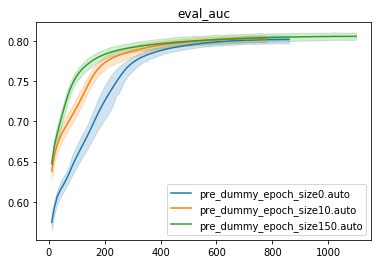

In [144]:
for r in report_list:
    show_valid_lc(r['config']['exp_name'], r['indicator'])
plt.show()

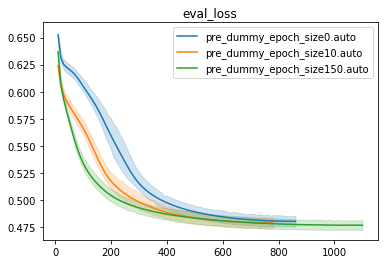

In [152]:
for r in report_list:
    show_valid_lc(r['config']['exp_name'], r['indicator'], idc='eval_loss')
plt.show()

## Test AUC

In [149]:
for r in report_list:
    summarize_test_res(r)

pre_dummy_epoch_size0.auto:	Best epoch at  862.0±66.9 	Valid AUC: 80.2291±0.6300	Test AUC: 80.2399±0.2135	All Test AUC: 80.2500
pre_dummy_epoch_size10.auto:	Best epoch at  776.0±16.7 	Valid AUC: 80.3139±0.5510	Test AUC: 80.2763±0.1107	All Test AUC: 80.4734
pre_dummy_epoch_size150.auto:	Best epoch at 1122.0±157.2	Valid AUC: 80.6169±0.5762	Test AUC: 80.5398±0.0801	All Test AUC: 80.6062


# `Debug`

## Simulated curve

In [154]:
def get_simu_res(report_dic):
    return report_dic['indicator']['simu_pred']['all']

simures_list = []
for r in report_list:
    simu_res = get_simu_res(r)
    simures_list.append(simu_res)
    
base_idx = 0
base_res = {k:v for k, v in sorted(simures_list[base_idx].items(), key=lambda it: it[1][1][-1] - it[1][1][0])}
descres_list = []
for i, simu_res in enumerate(simures_list):
    if i == base_idx:
        continue
    desc_res = {k:simu_res[k] for k in base_res.keys()}
    descres_list.append(desc_res)

## NDCG

In [157]:
for rep in report_list:
    r = rep['indicator']['RPsoft']['all']
    name = rep['config']['exp_name']
    print(f'{name:<20s}\tGood:Bad = {r["good"]}:{r["bad"]}')

pre_dummy_epoch_size0.auto	Good:Bad = 26:24
pre_dummy_epoch_size10.auto	Good:Bad = 44:6
pre_dummy_epoch_size150.auto	Good:Bad = 46:4


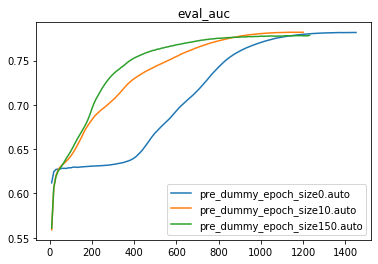

In [158]:
for r in report_list:
    show_valid_lc(r['config']['exp_name'], r['indicator'])
plt.show()

## Test AUC

## Simulated curve

In [129]:
def get_simu_res(report_dic):
    return report_dic['indicator']['simu_pred']['all']


simures_list = []
for r in report_list:
    simu_res = get_simu_res(r)
    simures_list.append(simu_res)
    

base_idx = 1
base_res = {k:v for k, v in sorted(simures_list[base_idx].items(), key=lambda it: it[1][1][-1] - it[1][1][0])}
descres_list = []
for i, simu_res in enumerate(simures_list):
    if i == base_idx:
        continue
    desc_res = {k:simu_res[k] for k in base_res.keys()}
    descres_list.append(desc_res)

## NDCG

In [132]:
for rep in report_list:
    r = rep['indicator']['RPsoft']['all']
    name = rep['config']['exp_name']
    print(f'{name:<20s}\tGood:Bad = {r["good"]}:{r["bad"]}')

assist09            	Good:Bad = 81:29
assist09pre10       	Good:Bad = 109:1


## Learning curve

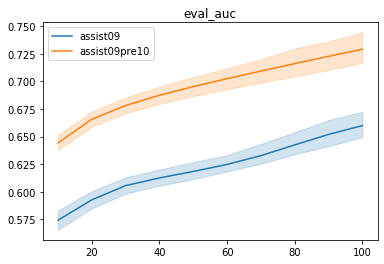

In [134]:
for r in report_list:
    show_valid_lc(r['config']['exp_name'], r['indicator'])
plt.show()

## Test AUC

In [136]:
def summarize_test_res(rep):
    print(rep['config']['exp_name'], end=':\t')
    s = pd.Series([rep['best']['auc_epoch'][str(i)] for i in range(5)])
    print(f'Best epoch at {s.mean():>6.1f}±{s.std():<5.1f}', end='\t')
    s = pd.Series([rep['best']['auc'][str(i)] for i in range(5)])
    print(f'Valid AUC: {s.mean()*100:.4f}±{s.std()*100:.4f}', end='\t')
    s = rep['indicator']['test_auc']['all'][0]
    print(f'Test AUC: {s*100:.4f}')

In [137]:
for r in report_list:
    summarize_test_res(r)

assist09:	Best epoch at  100.0±0.0  	Valid AUC: 65.9936±1.4473	Test AUC: 67.4731
assist09pre10:	Best epoch at  100.0±0.0  	Valid AUC: 72.9030±1.7630	Test AUC: 74.9683


# `20_0310_edm2020_synthetic`

## Simulated curve

In [166]:
config_name = '20_0310_edm2020_synthetic'
report_list = []
for r in sorted([load_json(get_report_path(projectdir, e)) for e in get_exp_paths(projectdir, config_name)], key=lambda x: x['config']['pre_dummy_epoch_size']):
    report_list.append(r)

[r['config']['exp_name'] for r in report_list]

['pre_dummy_epoch_size0.auto',
 'pre_dummy_epoch_size10.auto',
 'pre_dummy_epoch_size150.auto']

In [167]:
def get_simu_res(report_dic):
    return report_dic['indicator']['simu_pred']['all']

simures_list = []
for r in report_list:
    simu_res = get_simu_res(r)
    simures_list.append(simu_res)
    
base_idx = 0
base_res = {k:v for k, v in sorted(simures_list[base_idx].items(), key=lambda it: it[1][1][-1] - it[1][1][0])}
descres_list = []
for i, simu_res in enumerate(simures_list):
    if i == base_idx:
        continue
    desc_res = {k:simu_res[k] for k in base_res.keys()}
    descres_list.append(desc_res)

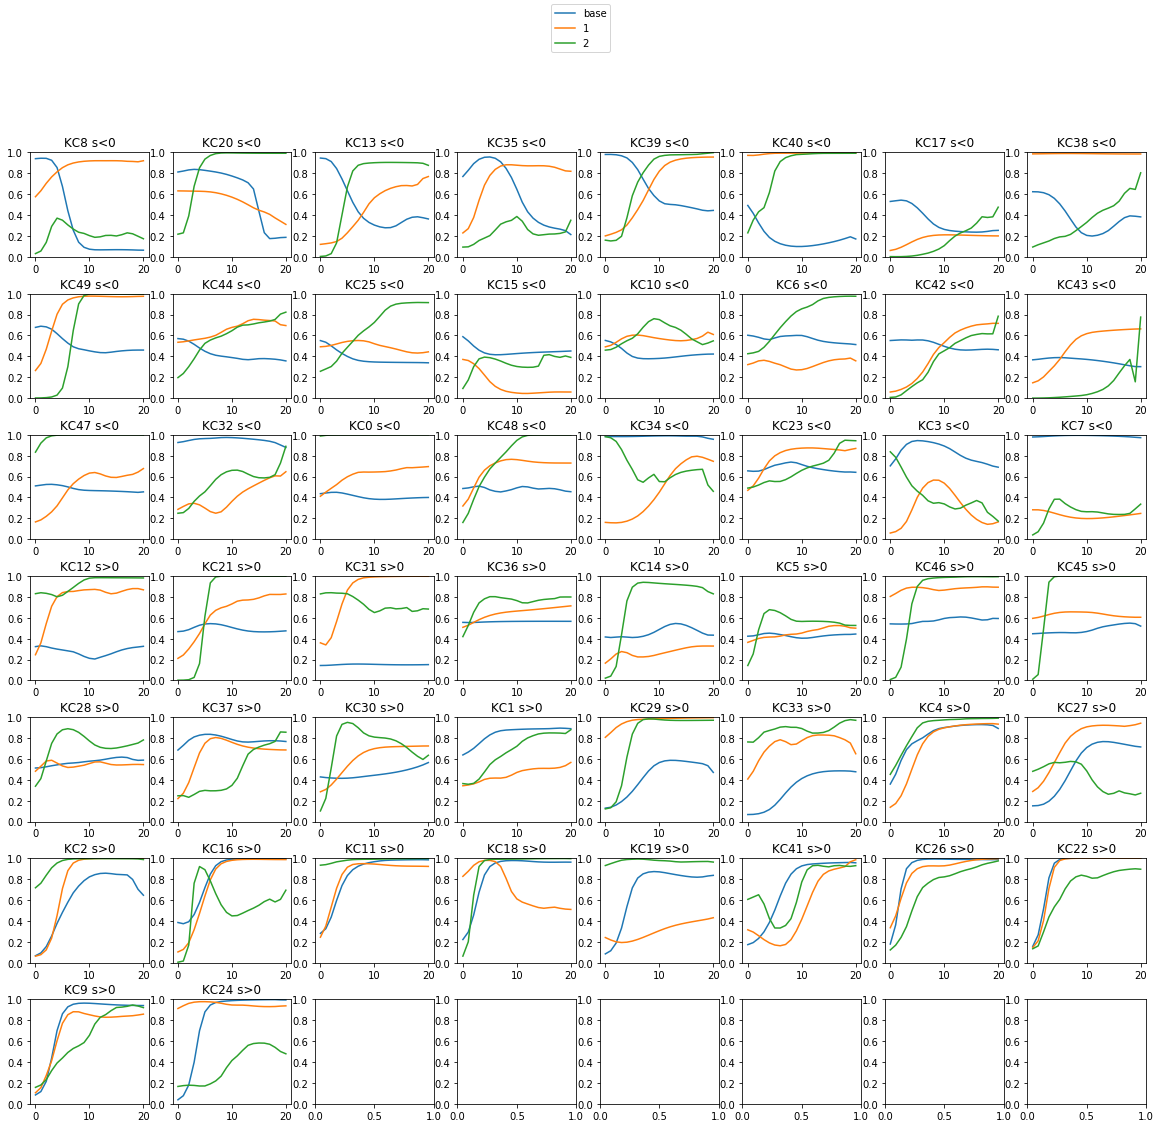

In [155]:
n_skills = report_list[base_idx]['config']['n_skills']
h, w = (n_skills+7)//8, 8
figscale = 2.5
hspace = 0.35
fig, axs = plt.subplots(h, w, figsize=(w*figscale, h*figscale))
plt.subplots_adjust(hspace=hspace)
for i, (v, (xidx, sanity)) in enumerate(list(base_res.items())[:h*w]):
    ax = axs[i//(w), i%(w)]
    ax.set_ylim([0, 1])
    ax.set_title('KC{} s{}0'.format(v, '>' if sanity[-1]>sanity[0] else '<'))
    sns.lineplot(xidx, sanity, ax=ax, label='base', palette="ch:2.5,.25")
    for i, desc_res in enumerate(descres_list):
        sns.lineplot(xidx, desc_res[v][1], ax=ax, label=str(i+1), palette="ch:2.5,.25")
    ax.get_legend().remove()
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center')
plt.show()

## NDCG

pre_dummy_epoch_size0.auto	0.7923±0.1306
pre_dummy_epoch_size10.auto	0.8948±0.1156
pre_dummy_epoch_size150.auto	0.8908±0.1139


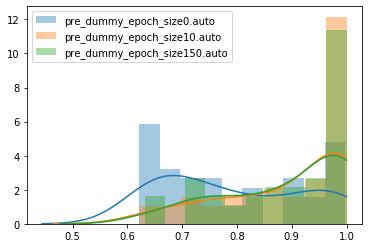

In [156]:
for rep in report_list:
    r = rep['indicator']['RPhard']['all']
    name = rep['config']['exp_name']
    sns.distplot(r, bins=10, label=name, kde_kws={'clip': (0.0, 1.0)})
    print(f'{name:<20s}\t{mean(r):.4f}±{stdev(r):.4f}')
plt.legend()
plt.show()

In [157]:
for rep in report_list:
    r = rep['indicator']['RPsoft']['all']
    name = rep['config']['exp_name']
    print(f'{name:<20s}\tGood:Bad = {r["good"]}:{r["bad"]}')

pre_dummy_epoch_size0.auto	Good:Bad = 26:24
pre_dummy_epoch_size10.auto	Good:Bad = 44:6
pre_dummy_epoch_size150.auto	Good:Bad = 46:4


## Learning curve

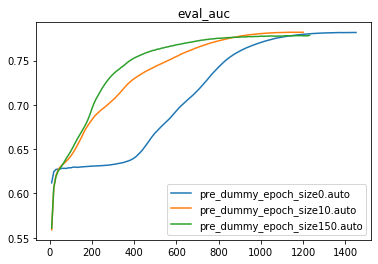

In [158]:
for r in report_list:
    show_valid_lc(r['config']['exp_name'], r['indicator'])
plt.show()

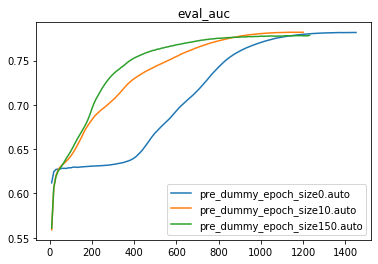

In [158]:
for r in report_list:
    show_valid_lc(r['config']['exp_name'], r['indicator'])
plt.show()

## Test AUC

In [ ]:
for r in report_list:
    show_valid_lc(r['config']['exp_name'], r['indicator'], idc='eval_loss')
    summarize_test_res(r, folds=1)
plt.show()

## Test AUC

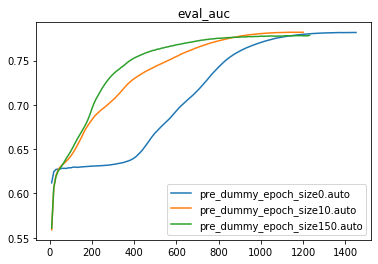

In [158]:
for r in report_list:
    show_valid_lc(r['config']['exp_name'], r['indicator'])
plt.show()

## Learning curve

In [157]:
for rep in report_list:
    r = rep['indicator']['RPsoft']['all']
    name = rep['config']['exp_name']
    print(f'{name:<20s}\tGood:Bad = {r["good"]}:{r["bad"]}')

pre_dummy_epoch_size0.auto	Good:Bad = 26:24
pre_dummy_epoch_size10.auto	Good:Bad = 44:6
pre_dummy_epoch_size150.auto	Good:Bad = 46:4


# `20_0310_edm2020_assist15`

## Simulated curve

In [168]:
config_name = '20_0310_edm2020_assist15'
report_list = []
for r in sorted([load_json(get_report_path(projectdir, e)) for e in get_exp_paths(projectdir, config_name)], key=lambda x: x['config']['pre_dummy_epoch_size']):
    report_list.append(r)

[r['config']['exp_name'] for r in report_list]

['pre_dummy_epoch_size0.auto',
 'pre_dummy_epoch_size10.auto',
 'pre_dummy_epoch_size150.auto']

In [169]:
def get_simu_res(report_dic):
    return report_dic['indicator']['simu_pred']['all']

simures_list = []
for r in report_list:
    simu_res = get_simu_res(r)
    simures_list.append(simu_res)
    
base_idx = 0
base_res = {k:v for k, v in sorted(simures_list[base_idx].items(), key=lambda it: it[1][1][-1] - it[1][1][0])}
descres_list = []
for i, simu_res in enumerate(simures_list):
    if i == base_idx:
        continue
    desc_res = {k:simu_res[k] for k in base_res.keys()}
    descres_list.append(desc_res)

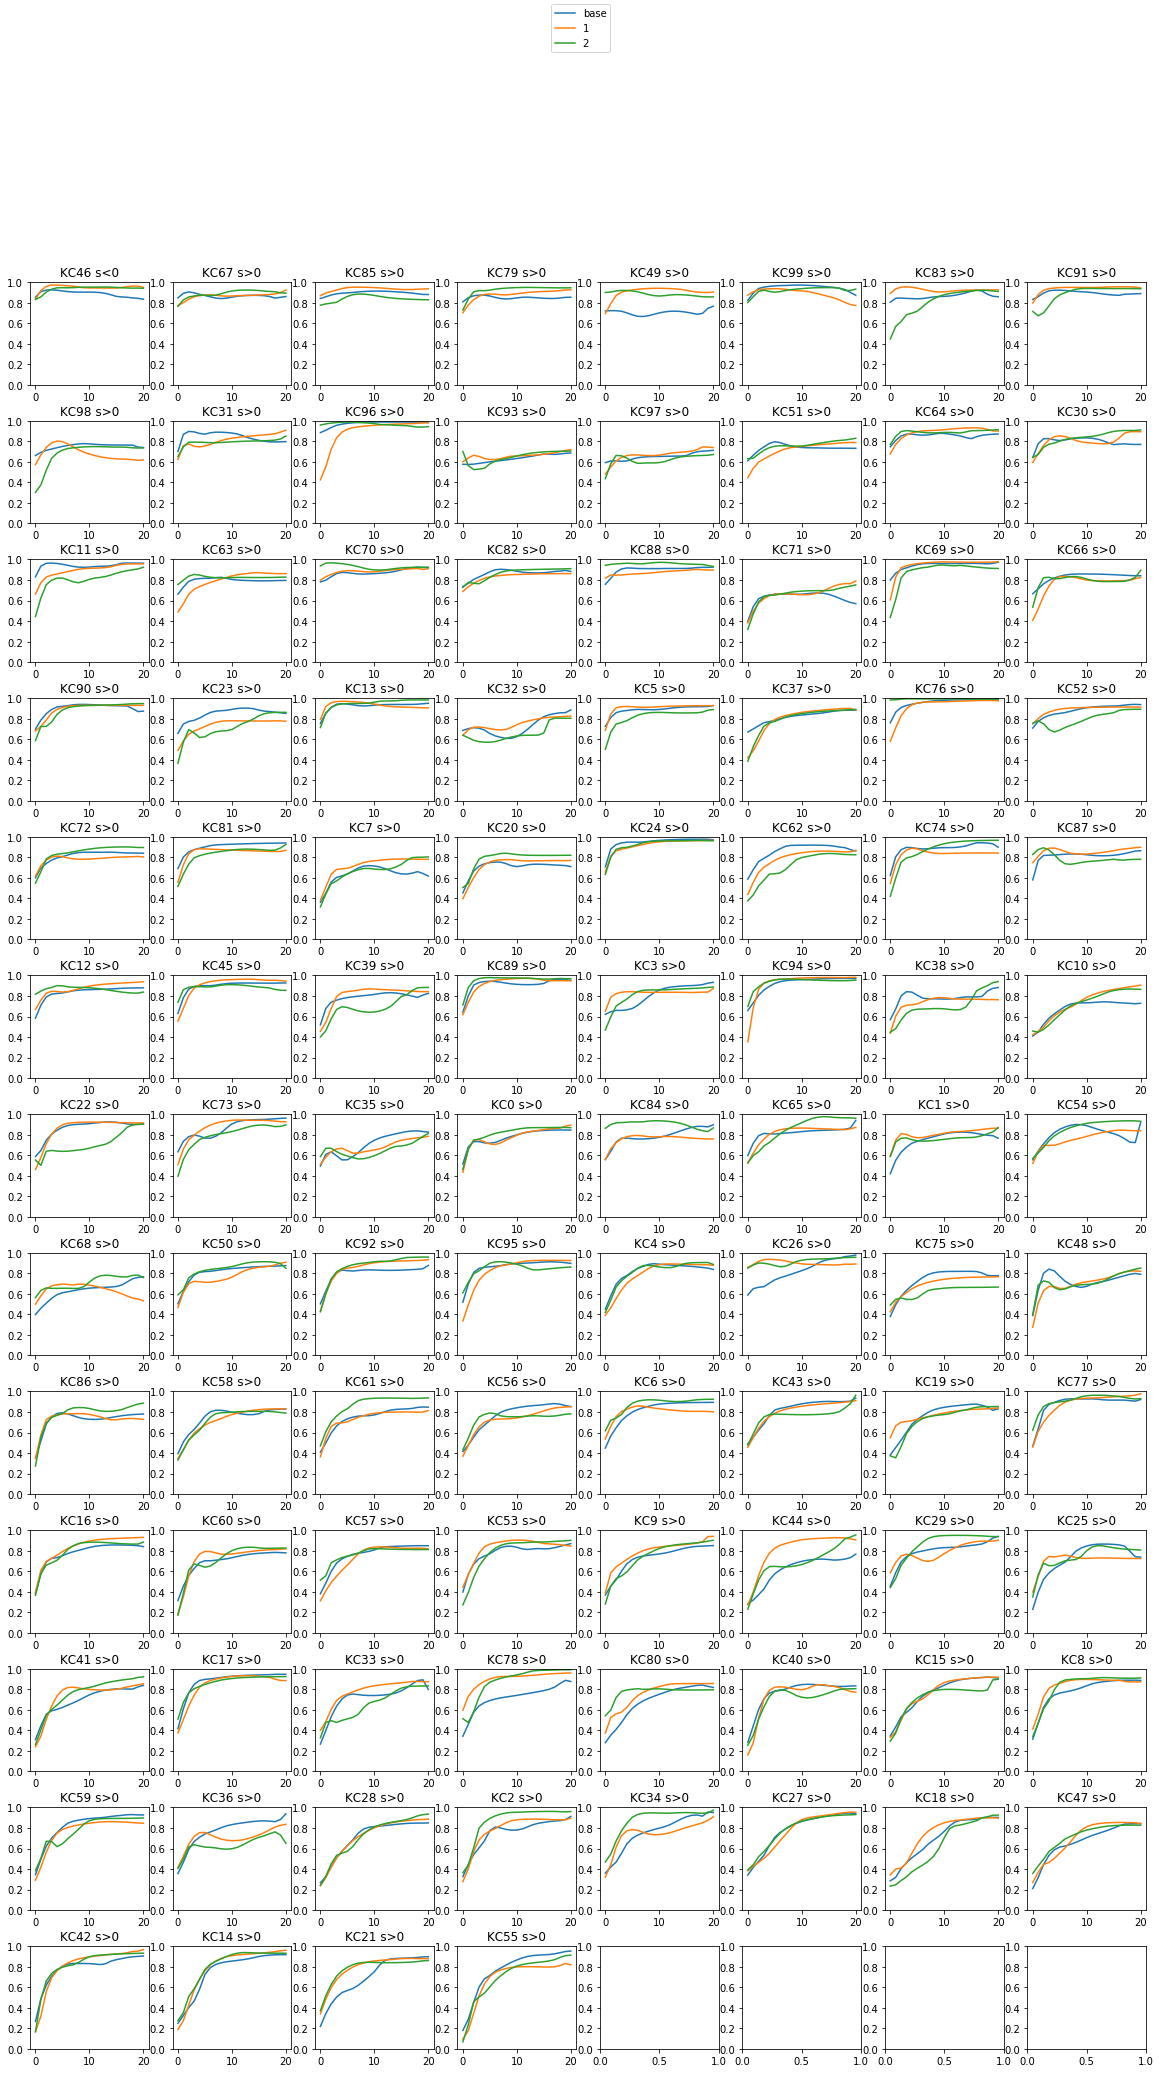

In [170]:
n_skills = report_list[base_idx]['config']['n_skills']
h, w = (n_skills+7)//8, 8
figscale = 2.5
hspace = 0.35
fig, axs = plt.subplots(h, w, figsize=(w*figscale, h*figscale))
plt.subplots_adjust(hspace=hspace)
for i, (v, (xidx, sanity)) in enumerate(list(base_res.items())[:h*w]):
    ax = axs[i//(w), i%(w)]
    ax.set_ylim([0, 1])
    ax.set_title('KC{} s{}0'.format(v, '>' if sanity[-1]>sanity[0] else '<'))
    sns.lineplot(xidx, sanity, ax=ax, label='base', palette="ch:2.5,.25")
    for i, desc_res in enumerate(descres_list):
        sns.lineplot(xidx, desc_res[v][1], ax=ax, label=str(i+1), palette="ch:2.5,.25")
    ax.get_legend().remove()
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center')
plt.show()

## NDCG

pre_dummy_epoch_size0.auto	0.9244±0.0915
pre_dummy_epoch_size10.auto	0.9211±0.0967
pre_dummy_epoch_size150.auto	0.9278±0.0927


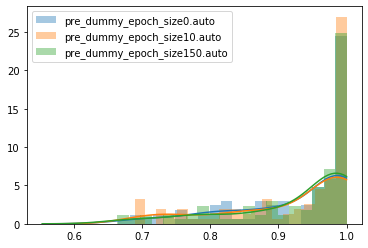

In [185]:
for rep in report_list:
    r = rep['indicator']['RPhard']['all']
    name = rep['config']['exp_name']
    sns.distplot(r, bins=20, label=name, kde_kws={'clip': (0.0, 1.0)})
    print(f'{name:<20s}\t{mean(r):.4f}±{stdev(r):.4f}')
plt.legend()
plt.show()

## Learning curve AUC

pre_dummy_epoch_size0.auto:	Best epoch at  896.0±39.7 	Valid AUC: 70.3211±0.2879	Test AUC: 70.3117±0.1366	Good:Bad = 99:1	All Test AUC: 70.4460
pre_dummy_epoch_size10.auto:	Best epoch at  800.0±33.9 	Valid AUC: 70.3640±0.2141	Test AUC: 70.3355±0.0890	Good:Bad = 99:1	All Test AUC: 70.7225
pre_dummy_epoch_size150.auto:	Best epoch at 1096.0±115.5	Valid AUC: 70.5937±0.1857	Test AUC: 70.5414±0.1263	Good:Bad = 95:5	All Test AUC: 70.9612


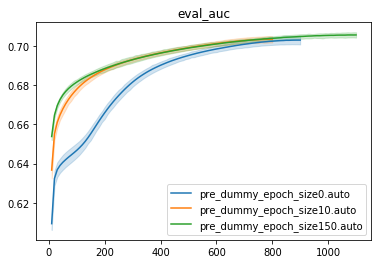

In [184]:
for r in report_list:
    show_valid_lc(r['config']['exp_name'], r['indicator'])
    summarize_test_res(r)
plt.show()

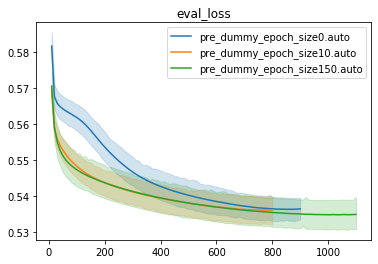

In [183]:
for r in report_list:
    show_valid_lc(r['config']['exp_name'], r['indicator'], idc='eval_loss')
plt.show()